In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

2025-01-09 12:29:19.456721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 12:29:19.456757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 12:29:19.458212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 12:29:19.466136: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
base_dir = '../final_dataset3'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [8]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

Found 1606 images belonging to 2 classes.
Found 343 images belonging to 2 classes.
Found 345 images belonging to 2 classes.


In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2025-01-09 12:31:48.570053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [10]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [12]:
# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


2025-01-09 12:32:21.951566: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2025-01-09 12:32:25.476259: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8b56594140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-09 12:32:25.476285: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2025-01-09 12:32:25.483217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736425945.592819    9082 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 28s 444ms/step - loss: 0.5747 - accuracy: 0.7783 - val_loss: 0.2965 - val_accuracy: 0.8921
Epoch 2/10
51/51 [==============================] - 20s 402ms/step - loss: 0.1914 - accuracy: 0.9271 - val_loss: 0.2722 - val_accuracy: 0.8863
Epoch 3/10
51/51 [==============================] - 19s 374ms/step - loss: 0.1211 - accuracy: 0.9583 - val_loss: 0.1871 - val_accuracy: 0.9446
Epoch 4/10
51/51 [==============================] - 19s 374ms/step - loss: 0.0762 - accuracy: 0.9770 - val_loss: 0.1876 - val_accuracy: 0.9271
Epoch 5/10
51/51 [==============================] - 20s 385ms/step - loss: 0.1285 - accuracy: 0.9433 - val_loss: 0.2916 - val_accuracy: 0.8834
Epoch 6/10
51/51 [==============================] - 19s 379ms/step - loss: 0.0772 - accuracy: 0.9726 - val_loss: 0.2241 - val_accuracy: 0.9125
Epoch 7/10
51/51 [==============================] - 19s 379ms/step - loss: 0.0334 - accuracy: 0.9894 - val_loss: 0.1653 - val_accuracy: 0.9475
Epoch 8/10

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

11/11 [==============================] - 5s 498ms/step - loss: 0.1914 - accuracy: 0.9275
Test accuracy: 0.9275362491607666


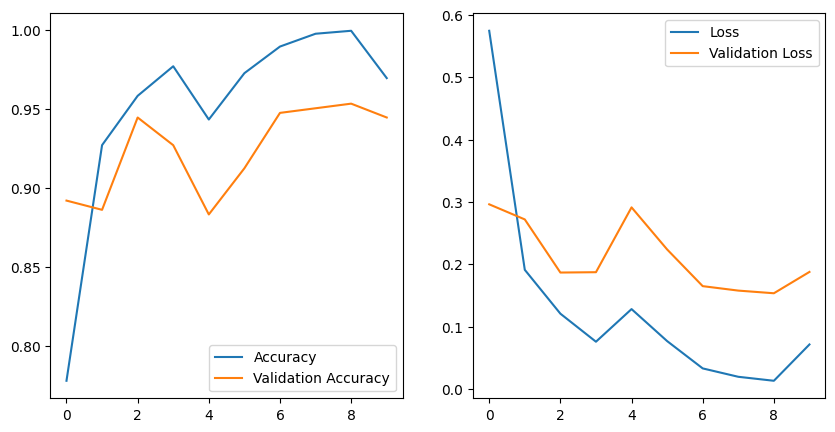

In [16]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [17]:
predictions = model.predict(test_generator)

11/11 [==============================] - 4s 324ms/step


In [18]:
binary_predictions = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes

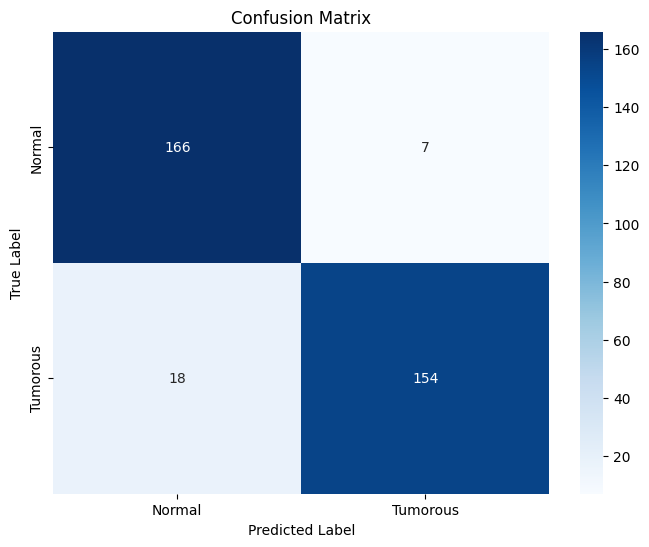

In [19]:
#Confussion matrix
cm = confusion_matrix(true_labels, binary_predictions)
classes = ['Normal','Tumorous']
#Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()